ДЗ выполнили: Аверьянов Николай и Тихонов Сергей. БЭК181.

Месячные данные представляют собой выбросы СО2 от производства электроэнергии. В этой работе рассматриваются выбросы углекислого газа при производстве электроэнергии от природного газа.

Ссылка: https://www.kaggle.com/txtrouble/carbon-emissions

Данные скачаны и предобработаны в представленном ноутбуке ниже.

In [ ]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt
import matplotlib.pylab

import pandas as pd
import numpy as np
import datetime

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.simplefilter(action="ignore")

In [ ]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

## Задание 1

«Взять языка». Возьми месячный временной ряд. Можно не один, а несколько, чтобы использовать дополнительные ряды как предикторы основного. Не бери цены финансовых инструментов, так как их приращение плохо прогнозируется в силу эффективности рынка. Разумно взять реальные показатели. Если очень хочется работать с финансовыми данными, можно взять волатильность, она прогнозируется хорошо. Максимально чётко укажи, откуда взяты ряды. Если ряды парсились, то приведи код.

In [ ]:
!wget https://www.dropbox.com/s/e2xqswi5am514p4/monthly1.zip
! unzip -q monthly1.zip 

In [ ]:
# Предобработка месячных данных

dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
df = pd.read_csv("MER_T12_06.csv", parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse) 
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
ts['Value'] = pd.to_numeric(ts['Value'], errors='coerce')
ts1 = ts[ts['Description'] == 'Natural Gas Electric Power Sector CO2 Emissions']
ts1 = ts1.asfreq('M', method='bfill')
ts1 = ts1.loc['1987':]
ts1 = pd.Series(ts1.Value)

In [ ]:
# сделаем разбиение на train/test для месячных данных

train_df_ts1 = ts1.loc[:'2015-06-30']
test_df_ts1  = ts1.loc['2015-07-30':]

## Задание 2

«Намалевич». Построй графики рядов, графики автокорреляционных функций, графики с нарезкой ряда на годы для иллюстрации сезонности.

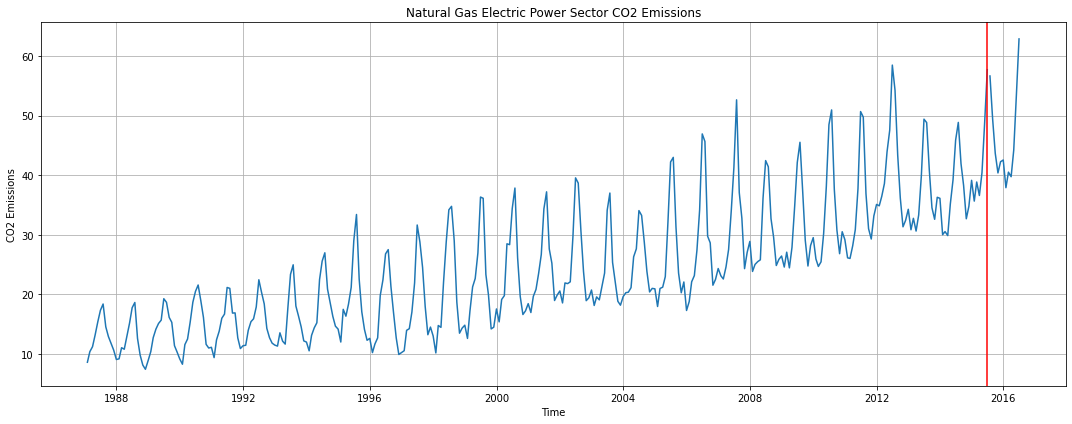

In [ ]:
# Отрисуем временной ряд для месячных данных

plt.figure(figsize=(15, 6))
plt.plot(train_df_ts1.index, train_df_ts1, color='#1f77b4')
plt.plot(test_df_ts1.index, test_df_ts1, color='#1f77b4')
plt.axvline(x=train_df_ts1.index[-1], color='red')
plt.title('Natural Gas Electric Power Sector CO2 Emissions')
plt.xlabel('Time')
plt.ylabel('CO2 Emissions')
plt.grid(b=1)
plt.tight_layout()
plt.show()

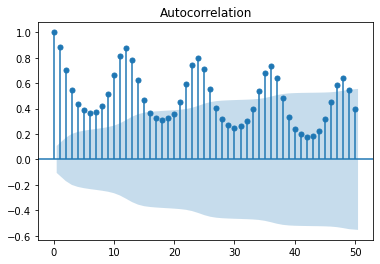

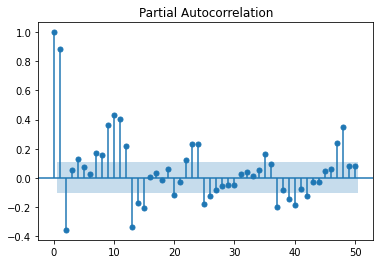

In [ ]:
# График для автокорреляционной функции

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_df_ts1, lags=50);
plot_pacf(train_df_ts1, lags=50);

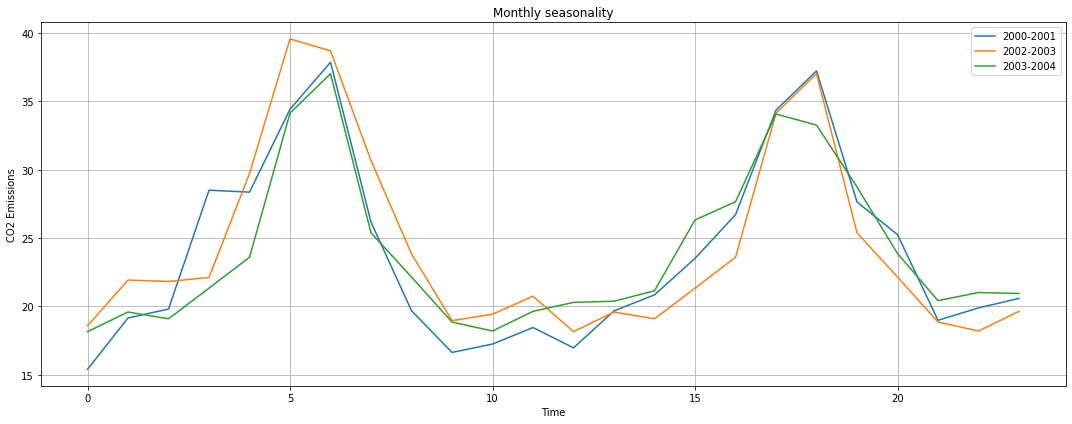

In [ ]:
# Разобьём месячный временной ряд по годам и построим их для иллюстрации сезонности
# Вывожу только 3 года, тк всего 30 лет и если вывести все на одном графике, то получится "каша"

part1 = ts1.loc['2000':'2001']
part2 = ts1.loc['2002':'2003']
part3 = ts1.loc['2003':'2004']

plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(part1)), part1, label='2000-2001')
plt.plot(np.arange(len(part2)), part2, label='2002-2003')
plt.plot(np.arange(len(part3)), part3, label='2003-2004')
plt.title('Monthly seasonality')
plt.xlabel('Time')
plt.ylabel('CO2 Emissions')
plt.grid(b=1)
plt.tight_layout()
plt.legend()
plt.plot();

## Задание 3

«Твиттер». Кратко прокомментируй полученные графики. Явлются ли ряды сезонными? есть ли тренд? стационарны ли ряды? есть ли точки излома? растёт ли амплитуда колебаний ряда? Возьми логарифм ряда, если душа тянется к логарифму.

Комментарий: 

1) Месячный времянной ряд обладает сезонностью, что иллюстрируется на графике автокорреляционной функции примерно каждые 12 точек. Поскольку данные месячные, можно заключить, что имеет место месячная сезонность. Данное предположение подтверждается после разбиения временного ряда на повторяющиеся участки по длине сезонной составляющей.

2) Имеет место возрастающий тренд эмиссии углекислого газа для получения электричества из природного газа.

3) Ряд нестационарен, поскольку после визуализации ряда видно, что предпосылка о постоянном математическом ожидании не выполняется. Данный факт подтверждается формальным тестом KPSS ниже.

4) Явновыраженной точки излома нет.

5) Амплитуда колебаний ряда не растёт, скорее имеет место аддитивная сезонность.

In [ ]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

kpss_test(train_df_ts1)
# p-value=0 => H_0 отвергается (нулевая гипотеза о стационарности ряда)

Results of KPSS Test:
Test Statistic           3.09
p-value                  0.01
Lags Used               10.00
Critical Value (10%)     0.35
Critical Value (5%)      0.46
Critical Value (2.5%)    0.57
Critical Value (1%)      0.74
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


## Задание 4

«Двенадцать месяцев». Необходимо исследовать качество прогнозов минимум 6 моделей:

• Наивная, $\hat{y}_{t+1} = y_{t}$.

• Сезонная наивная, $\hat{y}_{t+1} = y_{t+1−12}$.

• SARIMA(1, 1, 1)(1, 0, 0)[12].

• Алгоритм Хиндмана-Хандакара автоматического подбора SARIMA.

• ETS(AAA)

• ETS с автоматическим выбором по AIC.

Сравни качество прогнозов по средней абсолютной ошибке MAE на тестовой выборке. В качестве тестовой выборки возьми последний год наблюдений, в качестве обучающей — все остальные наблюдения.

In [ ]:
# Функция для визуализации 
def plot_of_series(y_train, y_test, y_pred):

    plt.figure(figsize=(15, 6))
    plt.plot(train_df_ts1.index, y_train, label='Train', color='#1f77b4')
    plt.plot(test_df_ts1.index, y_test, label='Test', color='#1f77b4')
    plt.plot(test_df_ts1.index, y_pred, label='Pred', color='#9467bd')
    plt.axvline(x=train_df_ts1.index[-1], color='red')
    plt.xlabel('Time')
    plt.ylabel('CO2 Emissions')
    plt.grid(b=1)
    plt.tight_layout()
    plt.legend()
    plt.show()  

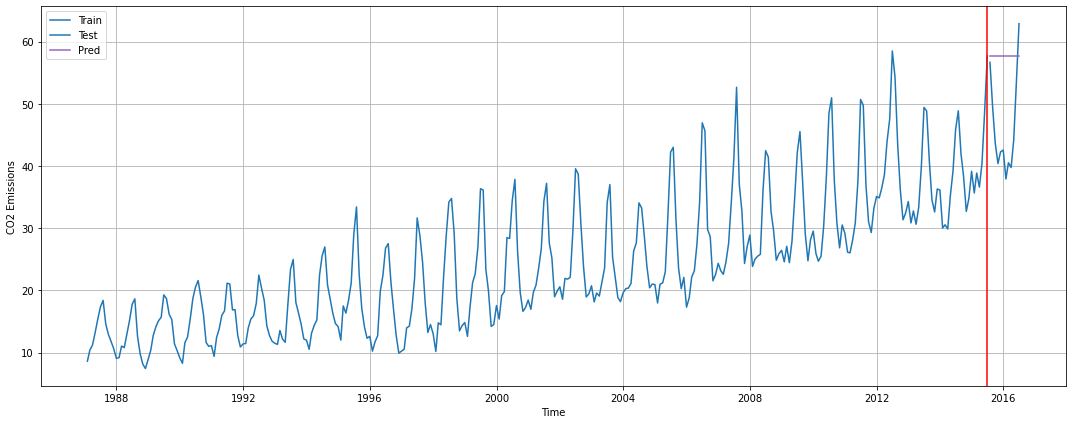

MAE: 12.421833333333332


In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_absolute_error
fh = ForecastingHorizon(test_df_ts1.index, is_relative=False)

# Наивная модель
forecaster = NaiveForecaster(strategy='last')
forecaster.fit(train_df_ts1)
y_pred = forecaster.predict(fh)

plot_of_series(train_df_ts1, test_df_ts1, y_pred)
print('MAE:', mean_absolute_error(test_df_ts1, y_pred))

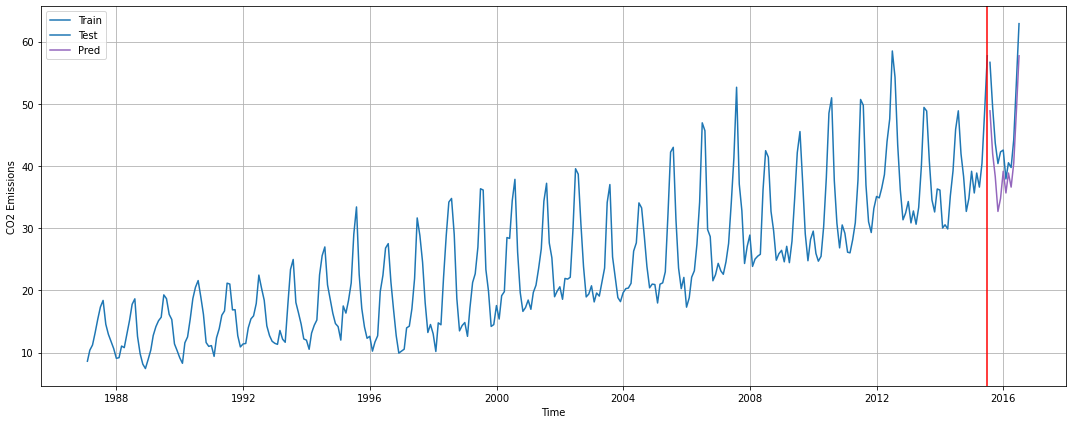

MAE: 4.985166666666666


In [ ]:
# Наивная модель с сезонностью
forecaster = NaiveForecaster(strategy='last', sp=12)
forecaster.fit(train_df_ts1)
y_pred = forecaster.predict(fh)

plot_of_series(train_df_ts1, test_df_ts1, y_pred)
print('MAE:', mean_absolute_error(test_df_ts1, y_pred))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


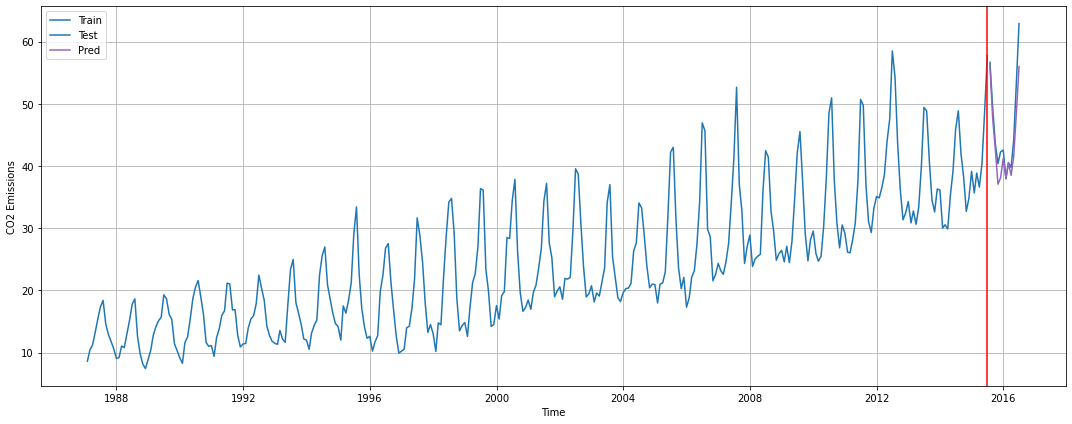

MAE: 2.311312575887198


In [ ]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

# ARIMA
forecaster = ARIMA(
    order = (1, 1, 1),
    seasonal_order=(1, 0, 0, 12)
)
forecaster.fit(train_df_ts1)
y_pred = forecaster.predict(fh)
plot_of_series(train_df_ts1, test_df_ts1, y_pred)
print('MAE:', mean_absolute_error(test_df_ts1, y_pred))

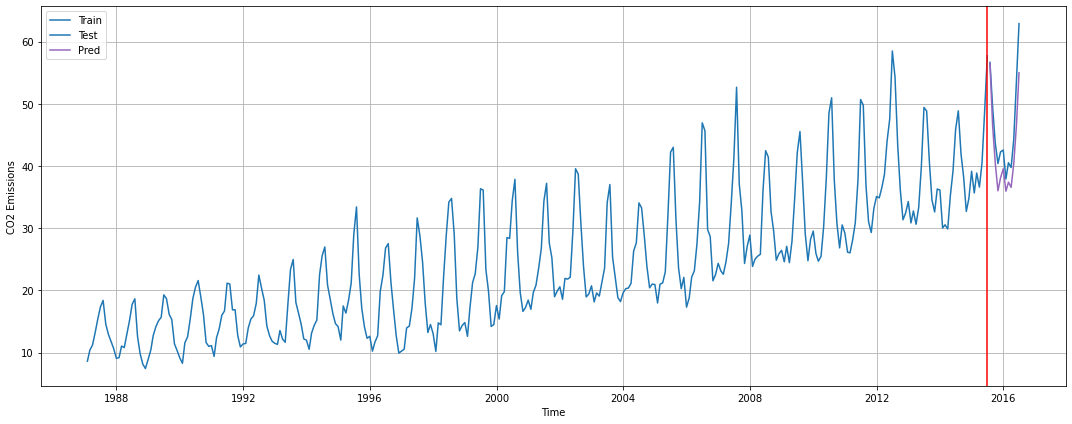

MAE: 3.7590243626446345


In [ ]:
# AutoARIMA
forecaster = AutoARIMA(sp=12, d=1, max_p=3, max_q=3, suppress_warnings=True)
forecaster.fit(train_df_ts1)
y_pred = forecaster.predict(fh)
plot_of_series(train_df_ts1, test_df_ts1, y_pred)
print('MAE:', mean_absolute_error(test_df_ts1, y_pred))

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

train_ets = train_df_ts1.copy()
train_ets.index = pd.PeriodIndex(train_ets.index)
test_ets = test_df_ts1.copy()
test_ets.index = pd.PeriodIndex(test_ets.index)
fh = ForecastingHorizon(test_ets.index, is_relative=False)

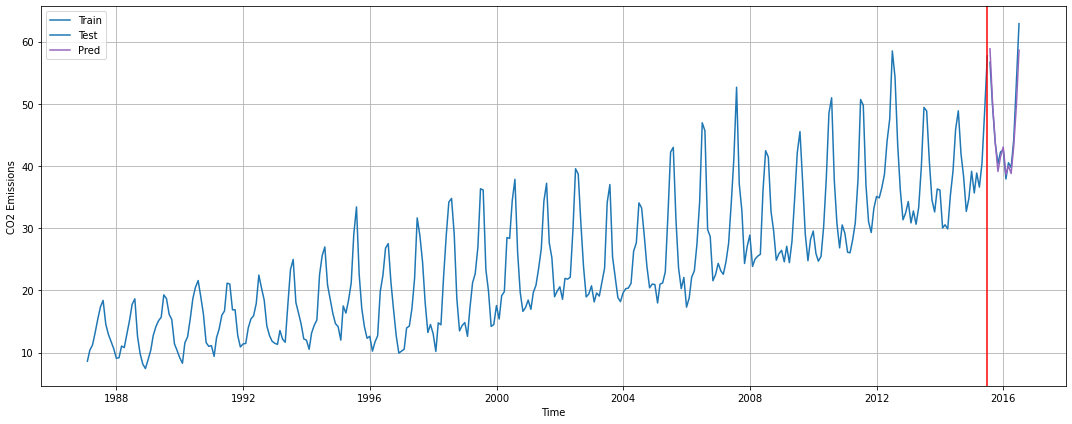

MAE: 1.3697515160539055


In [ ]:
# ETS(AAA)
forecaster = ExponentialSmoothing(trend='add', seasonal='add', sp=12)
forecaster.fit(train_ets)
y_pred = forecaster.predict(fh)
plot_of_series(train_ets, test_df_ts1, y_pred)
print('MAE:', mean_absolute_error(test_df_ts1, y_pred))

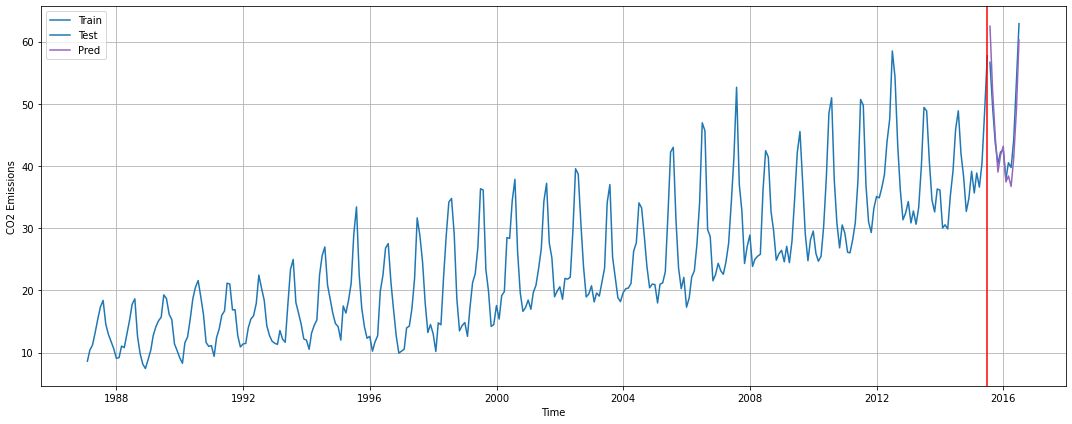

MAE: 2.306224845075956


In [ ]:
# AutoETS
forecaster = AutoETS(auto=True, sp=12, njobs=-1)
forecaster.fit(train_ets)
y_pred = forecaster.predict(fh)
plot_of_series(train_ets, test_df_ts1, y_pred)
print('MAE:', mean_absolute_error(test_df_ts1, y_pred))

**Итог**: модель ETS(AAA) получила наименьший MAE на тестовой выборке.

## Бонус кроссвалидация 

In [ ]:
def build_expanding_plan(ts, horizon, start_window, max_window, step_size):

    anchor_index = start_window 
    end_index = anchor_index + horizon 
    plans = []

    train_ts = ts1[0 : anchor_index]
    test_ts = ts1[anchor_index : end_index]
    plans.append((train_ts, test_ts))

    while end_index < len(ts1):
        anchor_index = anchor_index + step_size
        end_index = anchor_index + horizon
        train_ts = ts1[0 : anchor_index]
        test_ts = ts1[anchor_index : end_index]

        plans.append((train_ts, test_ts))
    
    return plans

In [ ]:
def CV(forecaster, plans):

    mae = []
    for plan in plans:
        plan[0].index = pd.PeriodIndex(plan[0].index)
        plan[1].index = pd.PeriodIndex(plan[1].index)
        fh = ForecastingHorizon(plan[1].index, is_relative=False)
        forecaster.fit(plan[0])
        y_pred = forecaster.predict(fh)
        mae.append(mean_absolute_error(plan[1], y_pred))
        
    return np.median(mae)

Протестируем кроссвалидацию на различных ETS/ARIMA моделях. Как удалось выяснить в задании 4, выбранные данные лучше всего описывает ETS(AAA) модель с сезонностью. Убедимся в этом с помощью кроссвалидации.

In [ ]:
start_window = int(0.8 * len(ts1))
plans = build_expanding_plan(ts1, 1, start_window, 355, 1)

In [ ]:
# Начиная с 283 (80% временного ряда), постепенно делая предсказание на 1 шаг вперед (71 всего), достигли 354 (длинна временного ряда)
start_window, len(plans), len(ts1)

(283, 71, 354)

In [ ]:
# ETS(AAA)[12]
CV(ExponentialSmoothing(trend='add', seasonal='add', sp=12), plans)

1.613048885824231

In [ ]:
# ARIMA(1, 1, 0)(1, 0, 0)[12] - взял немного другую модель (та, которая указана в задании, не сходилась)
CV(ARIMA(order = (1, 1, 0), seasonal_order=(1, 0, 0, 12)), plans)

2.0946252860417047

**Итог**: как и в случае с обыкновенной MAE на тесте, победил ETS(AAA)[12], но, как и во многих задачах эконометрики / машинного обучения, многое зависит от разбиения.

## Задание 6

«Хождение в народ». Скачай панельные данные RLMS. Можешь выбрать данные по домохозяйствам, а можешь по индивидам, https://www.hse.ru/rlms/. Регистрация там бесплатная и без смс. Описание огромного количества переменных есть в https://www.hse.ru/rlms/code. К сожалению, данные RLMS выложены в закрытых форматах. Это маленький позор, я с ним пытался бороться, но пока безуспешно. Если уж никак не удаётся загрузить большую панельку из приватного формата сразу в открытыйсофт, открой её в родном закрытом софте и экспортируй нужные переменные в свободный .csv.

In [ ]:
!wget https://www.dropbox.com/s/75zo1jk1nx0ckf4/unformatted.csv

In [ ]:
# Обработал табличку RLMS в другом стат-пакете, поскольку питон очень долго загружал и конвертировал полную таблицу RLMS
df = pd.read_csv('unformatted.csv') 
df.columns = ['idind', 'year', 'educ', 'wage', 'educyears']

df.educyears.replace(0, np.nan, inplace=True)
df.replace('ОТКАЗ ОТ ОТВЕТА', np.nan, inplace=True)
df.replace('НЕТ ОТВЕТА', np.nan, inplace=True)
df.replace('ЗАТРУДНЯЮСЬ ОТВЕТИТЬ', np.nan, inplace=True)
df.dropna(inplace=True)
df.wage = pd.to_numeric(df.wage)
df.educyears = pd.to_numeric(df.educyears)
df['lnwage'] = np.log(df.wage)
df.drop('wage', inplace=True, axis=1)

## Задание 7

«Кому на Руси жить хорошо?». Сформулируй пусть не особо глубокий, но всё же вопрос. Уровня «Помогает ли потребление огурцов домодчадцами предсказать доход главы семейства?» вполне достаточно. В данных RLMS много пропусков, поэтому погоня за большим количество предикторов приведёт к выбрасыванию всех наблюдений. Для данного игрового задания одного предиктора достаточно.

В данном исследовании мы хотим оценить известное уравнение Минсера, определяющее зависимость логарифма заработной платы от количества лет обучения в самом простом его виде:

$$
ln(wage_i) = \beta_{0} + \beta_{1} educyears_i + \varepsilon_i
$$

Коэффициент $\beta_{1}$ будет означать отдачу от образования: на сколько процентов в среднем изменится з/п при увеличении количества лет обучения на 1 год. 

**Исследовательский вопрос**: является ли отдача от образования в России низкой?

## Задание 8

«Сделай красиво!» Визуализируй данные с целью графического ответа на поставленный вопрос.

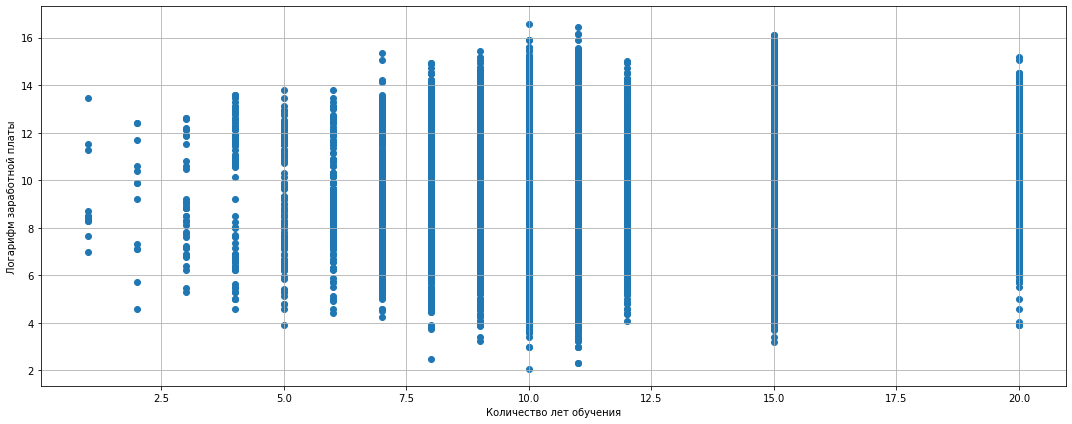

In [ ]:
plt.figure(figsize=(15, 6))
plt.scatter(df.educyears, df.lnwage)
plt.xlabel('Количество лет обучения')
plt.ylabel('Логарифм заработной платы')
plt.grid(b=1)
plt.tight_layout()
plt.show()

Ответ на исследовательский вопрос: по графику видно, что с ростом количества лет обучения логарифм з/п растёт очень слабо.

Ответ по визуализации сильно осложняется количеством наблюдений (их 145980 штук) и высокой дисперсией з/п у людей с одинаковым количеством лет обучения.

Однако можно выделить несколько интересных патернов на графике: 
1) С ростом количества лет обучения дисперсия логарифма заработной платы увеличивается.
2) Зависимость не линейная: при большом количестве лет обучения (аспирантура) ЗП начинает снижаться.

## Задание 9 

«Три сестры». Оцени три модели: сквозную модель, FE-модель, RE-модель. С помощью подходящих тестов выбери наилучшую.

In [ ]:
!pip install linearmodels

In [ ]:
from linearmodels.panel import PooledOLS, PanelOLS, RandomEffects
import statsmodels.api as sm

In [ ]:
year = pd.Categorical(df.year)
df = df.set_index(['idind', 'year'])
df['year'] = year

In [ ]:
exog_vars = ['educyears']
exog = sm.add_constant(df[exog_vars])

# Pooled OLS
mod_pooled = PooledOLS(df.lnwage, exog)
pooled_res = mod_pooled.fit()

In [ ]:
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                 lnwage   R-squared:                        0.0152
Estimator:                  PooledOLS   R-squared (Between):              0.0023
No. Observations:              145969   R-squared (Within):               0.0021
Date:                Sun, Jun 13 2021   R-squared (Overall):              0.0152
Time:                        06:42:55   Log-likelihood                -2.583e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2246.0
Entities:                       29603   P-value                           0.0000
Avg Obs:                       4.9309   Distribution:                F(1,145967)
Min Obs:                       1.0000                                           
Max Obs:                       24.000   F-statistic (robust):             2246.0
                            

In [ ]:
# FE модель
mod_fe = PanelOLS(df.lnwage, exog, entity_effects=True)
fe_res = mod_fe.fit()

In [ ]:
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 lnwage   R-squared:                        0.0021
Estimator:                   PanelOLS   R-squared (Between):              0.0025
No. Observations:              145969   R-squared (Within):               0.0021
Date:                Sun, Jun 13 2021   R-squared (Overall):              0.0151
Time:                        06:43:04   Log-likelihood                -2.152e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      246.10
Entities:                       29603   P-value                           0.0000
Avg Obs:                       4.9309   Distribution:                F(1,116365)
Min Obs:                       1.0000                                           
Max Obs:                       24.000   F-statistic (robust):             246.10
                            

## F-test (PooledOLS vs. FE)


$H_{0}: \alpha_1 = \ldots = \alpha_N \quad$ (Выбираем PooledOLS)

$H_{1}: \exists \alpha_i \neq \alpha_j \quad$ (Выбираем FE)

$\quad$

$F^{obs} = \frac{(RSS_{pooled}-RSS_{FE})/(N-1)}{RSS_{FE}/(NT - N - k)}$


Вывод: p-value = 0, значит нулевая гипотеза отвергается, значит делаем выбор в пользу FE спецификации (тест выдаёт сама модель, он прямо под RE).

In [ ]:
# RE модель
mod_re = RandomEffects(df.lnwage, exog, check_rank=True)
re_res = mod_re.fit()

In [ ]:
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 lnwage   R-squared:                        0.5671
Estimator:              RandomEffects   R-squared (Between):              0.0137
No. Observations:              145969   R-squared (Within):               0.0021
Date:                Sun, Jun 13 2021   R-squared (Overall):              0.0098
Time:                        06:43:16   Log-likelihood                -2.304e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.912e+05
Entities:                       29603   P-value                           0.0000
Avg Obs:                       4.9309   Distribution:                F(1,145967)
Min Obs:                       1.0000                                           
Max Obs:                       24.000   F-statistic (robust):             764.23
                            

## Тест Хаусмана


$H_{0}: corr(\alpha_{i}, X_{it}) = 0 \quad$ (RE и FE состоятельные, RE - эффективная)

$H_{1}: corr(\alpha_{i}, X_{it}) \neq 0 \quad$ (RE - несостоятельные)


In [ ]:
# q = \beta_fe - \beta_re
# Var(\beta_fe) - Var(\beta_re) 

from scipy.stats import chi2

q = 0.0046 - 0.0188
var_q = 0.0025 ** 2 - 0.0019 ** 2
chi2_obs = q * (var_q ** (-1)) * q 
chi2_cr = chi2.pdf(0.05, 1)

if chi2_obs < chi2_cr:
    print('H_0 не отвергается')
else:
    print('H_0 отвергается')

H_0 отвергается


Вывод: поскольку нулевая гипотеза отвергается, можем выбрать модель FE.


**Вывод по всему блоку моделей**: проведя соответствующие тесты, мы можем заключить, что необходимо выбрать спецификацию модели FE. 


## Задание 10

«Ответ на главный вопрос». Ответь на поставленный вопрос.

1) **Pooled OLS**:

Коэффициент при количестве лет обучения значим, положительный и составляет $\beta_{1} = 0.0719$: при увеличении количества лет обучения на 1 год заработная плата в среднем меняется на 7.19%. 

2) **FE модель**:

Коэффициент при количестве лет обучения значим при любом уровне значимости и равен $\beta_{1} = 0.0683$: результат получился ниже, чем при использовании Pooled OLS. F-test показал, что стоит сделать выбору в пользу спецификация FE модели.

3) **RE модель**: 

Зависимость значимая при любом уровне значимости, при этом коэффициент, определяющий отдачу от образования равен $\beta_{1} = 0.0682$. Тест Хаусмана показал, что оценки RE статистически отличаются от оценок FE, в результате чего оценки RE модели не являются состоятельными и более эффективными. 

**Ответ на главный вопрос**: Действительно, делая вывод по использованным данным можно заключить, что отдача от образования в России низкая: при одном дополнительном годе обучения заработная плата в среднем увеличивается на 6.83%. Стоит учесть, что строилась простая парная регрессия (без контрольных переменных - возраст, опыт работы, город, пол, ...), в результате чего получается случай "пропущенных переменных" - оценка отдачи от образования завышена. В целом, в других работах российских исследователей, которые строили множественную регрессию, оценка составляет 2-4%, что является существенно ниже, чем, к примеру, в США, где по разным оценкам отдача от одного дополнительнього года обучения увеличивает зарплату в среднем на 10%.